In [1]:
import os
from itertools import product
import cv2

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from keras.preprocessing import image

%matplotlib inline

In [2]:
image_path = "/content/drive/MyDrive/Projects/3rd-Year-Project/NDWI/Processed Images/LC09_L2SP_147043_20220419_20220421_02_T1_SR_swir1.png"
cropped_image_path = "/content/Crop"
model_path = "/content/drive/MyDrive/Projects/3rd-Year-Project/NDWI/Model/NDWI_Rivers_Lakes_Trained_Model.h5"

In [3]:
dh = 1024
dw = 1024
img = Image.open(image_path)
w, h = img.size

grid = product(range(0, h-(h % dh), dh), range(0, w-(w % dw), dw))
for i, j in grid:
    if j+dw <= w:
        box = (j, i, j+dw, i+dh)
        out = os.path.join(cropped_image_path, f'{j}x{i}.png')
        cropped_img = img.crop(box)
        np_cropped_img = np.asarray(cropped_img)
        if np.all(np_cropped_img == np_cropped_img[0]):
            continue
        else:
            cropped_img.save(out)

In [4]:
model = tf.keras.models.load_model(model_path)

class_names = ["Lake", "River"]

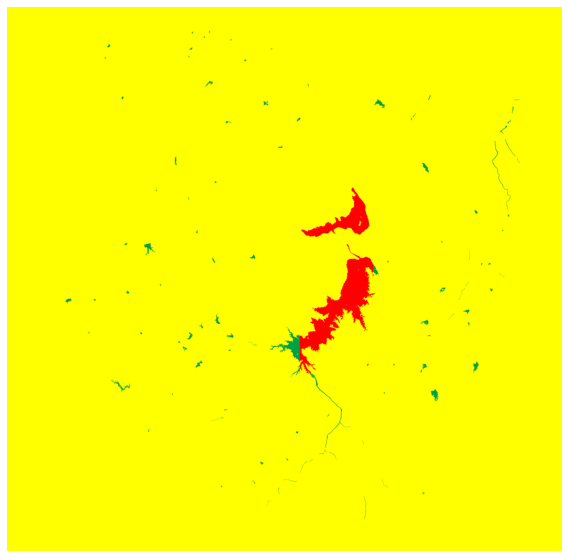

In [6]:
img_width, img_height = 1024, 1024
complete_image = [0.,255.,255.] * np.ones([w,h,3],dtype=np.float32)

for img_name in os.listdir(cropped_image_path):
    img = image.load_img(os.path.join(cropped_image_path, img_name))
    hsv = cv2.cvtColor(np.float32(img),cv2.COLOR_BGR2HSV)
    img = image.img_to_array(img)
    image1 = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)

    predictions = model.predict(img)

    score = tf.nn.softmax(predictions[0])

    low=np.array([300,0,0])
    high=np.array([400,100,100])

    mask=cv2.inRange(hsv,low,high)

    x, y = img_name.replace('.png', '').split('x')

    x, y = int(x), int(y)

    if np.argmax(score) == 0:
        complete_image[y:y+dw, x:x+dh][mask>0] = [0, 0, 255]
    else:
        complete_image[y:y+dw, x:x+dh][mask>0] = [70, 160, 0]

cv2.imwrite("result.png",complete_image)

img = mpimg.imread('result.png')
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(img)
plt.show()